<img width="50" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# Macroalgae data prep

_by Joe Hamman, October 7, 2021_

This notebook processes multiple data layers related to the modeling of macroalgae for the purpose
of carbon removal. The basic steps in this notebook are as follows:

1. load and normalize input datasets
2. build data pyamid for web map tool using `ndpyramid.pyramid_reproject`
3. merge data layers into a single multi-dimensional array
4. set storage encoding
5. write data to cloud object store in Zarr format


## imports and options


In [1]:
import xarray as xr
import fsspec
import pandas as pd
import numpy as np

import rioxarray  # noqa: F401
import datatree
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib import cm
from showit import image

from ndpyramid import pyramid_reproject
from carbonplan_data.metadata import get_cf_global_attrs
from carbonplan_data.utils import set_zarr_encoding
from carbonplan_styles.mpl import set_theme

import zarr


# options for data processing
pixels_per_tile = 128
levels = 6
mask_threshold = 0.01

# options for diagnostic plots
plot_diagnostics = True
theme = set_theme()
cmap = cm.get_cmap("cool_light").copy()
cmap.set_bad("0.5")

## helper functions


In [2]:
def compute_grid_area(da):
    """
    Compute the geographic area (in square meters) of every pixel in the data array provided.

    Parameters
    ----------
    da : xarray.DataArray
        DataArray with spatial coordinates longitude and latitude

    Returns
    -------
    areacella : xarray.DataArray
        DataArray with grid cell areas in square meters
    """
    R = 6.371e6
    SQM_PER_HA = 10000
    dϕ = np.radians((da["latitude"][1] - da["latitude"][0]).values)
    dλ = np.radians((da["longitude"][1] - da["longitude"][0]).values)
    dA = R ** 2 * np.abs(dϕ * dλ) * np.cos(np.radians(da["latitude"]))
    areacella = dA * xr.ones_like(da)

    return areacella / SQM_PER_HA


def load_data():
    ds = xr.Dataset()
    
    print('loading sensitive area masks')
    with fsspec.open("gs://carbonplan-research/macroalgae/data/raw/sensitive_area_maps_v2.nc", mode="rb") as f:
        ds_raw = xr.open_dataset(f).load()
        sensitive_areas = np.zeros(ds_raw['shipping_lanes'].values.shape)
        sensitive_areas[~np.isnan(ds_raw['marine_protected_areas'].values) & np.isnan(ds_raw['shipping_lanes'].values)] = 1
        sensitive_areas[np.isnan(ds_raw['marine_protected_areas'].values) & ~np.isnan(ds_raw['shipping_lanes'].values)] = 2
        sensitive_areas[np.isnan(ds_raw['marine_protected_areas'].values) & np.isnan(ds_raw['shipping_lanes'].values)] = 3
        ds["sensitive_areas"] = xr.DataArray(sensitive_areas, coords=ds_raw.coords, dims=("latitude", "longitude"))
    
    print('loading d2p')
    with fsspec.open("gs://carbonplan-research/macroalgae/data/raw/d2port.nc", mode="rb") as f:
        ds_raw = xr.open_dataset(f).load()
        ds['d2p'] = xr.DataArray(ds_raw['d2p'].values, dims=("latitude", "longitude"))
    
    print('loading nvar + harv')
#     for species in ['Sargassum','Eucheuma', 'Macrocystis', 'Porphyra', 'Saccharina']:
#         with fsspec.open(
#             f"gs://carbonplan-research/macroalgae/data/raw/mag0_output_std_lim_terms_{species}_f0.nc",
#             mode="rb",
#         ) as f:
#             ds_raw = xr.open_dataset(f, decode_cf=False).load()
#             ds_raw = xr.decode_cf(ds_raw.drop(["time1", "time8"]))
#             #ds[f'growth_{species.lower()}'] = ds_raw['Growth2']
#             ds[f'harv_{species.lower()}'] = ds_raw['harv']
#             ds[f'nharv_{species.lower()}'] = ds_raw['n_harv']
    
    with fsspec.open(
        "gs://carbonplan-research/macroalgae/data/raw/Preferred_species_f0_v2.nc",
        mode="rb",
    ) as f:
        ds_raw = xr.open_dataset(f).load()
#         ds["growth_preferred"] = xr.DataArray(
#             ds_raw["Growth"].values, dims=("latitude", "longitude")
#         )
        ds["species_preferred"] = xr.DataArray(
            ds_raw["index_H"].values, dims=("latitude", "longitude")
        )
        ds["harv_preferred"] = xr.DataArray(
            ds_raw["Harvest"].values, dims=("latitude", "longitude")
        )
        ds["nharv_preferred"] = xr.DataArray(
            ds_raw["nharv_H"].values, dims=("latitude", "longitude")
        )

    # hack to work around alignment issues
    print('loading elevation')
    with fsspec.open("gs://carbonplan-research/macroalgae/data/raw/gebco_cwm.nc", mode="rb") as f:
        ds["elevation"] = xr.DataArray(
            xr.open_dataset(f)["elevation"].values, dims=("latitude", "longitude")
        )

    print('loading d2sink')
    with fsspec.open("gs://carbonplan-research/macroalgae/data/raw/d2sink_fseq_maps_v3.nc", mode="rb") as f:
        ds_raw = xr.open_dataset(f).load()
        ds["d2sink"] = xr.DataArray(ds_raw["d2sink"].values, dims=("latitude", "longitude"))
        ds["fseq"] = xr.DataArray(ds_raw["fseq_100years"].values, dims=("latitude", "longitude"))
        ds["fseq_transport"] = xr.DataArray(ds_raw["fseq_100years_withtransport"].values, dims=("latitude", "longitude"))
        
    print('loading wave height')
    with fsspec.open(
        "gs://carbonplan-research/macroalgae/data/raw/ecmwf_swh_2003_9km.nc", mode="rb"
    ) as f:
        with xr.open_dataset(f) as ds_temp:
            # TODO: replace with proper calculation (waiting on email from UCI)
            ds["wave_height"] = xr.DataArray(
                ds_temp["swh_mean"].mean("time").values, dims=("latitude", "longitude")
            )

    print('loading mask')
    with fsspec.open(
        "gs://carbonplan-research/macroalgae/data/raw/mask_cbpm_2021_01_13.txt", mode="r"
    ) as f:
        df = pd.read_csv(f, sep=" ", header=None)
        ds["mask"] = xr.DataArray(df.values, dims=("latitude", "longitude"))
        ds["mask"] = ds["mask"].astype("float64")

    # Skipping for now. Not 100% sure how to parse this one.
    # with fsspec.open('gs://carbonplan-research/macroalgae/data/raw/area_twelfth_degree.txt', mode='r') as f:
    #     df = pd.read_csv(f, sep=' ', header=None)
    #     ds['area'] = xr.DataArray(df.values, dims=('latitude', 'longitude'))

    ds["longitude"] = ds["longitude"].where(ds["longitude"] < 180, ds["longitude"] - 360)

    ds["area"] = compute_grid_area(ds["mask"])

    return ds


def merge_layers(ds):
    da = ds.to_array(dim="variable").chunk(dict(x=pixels_per_tile, y=pixels_per_tile))
    merged_ds = da.to_dataset(name="all_variables")
    return merged_ds

## load data


In [3]:
ds = load_data()

display(ds)
# or ds.info()

loading sensitive area masks
loading d2p
loading nvar + harv
loading elevation
loading d2sink
loading wave height
loading mask


<xarray.Dataset>
Dimensions:            (latitude: 2160, longitude: 4320)
Coordinates:
  * latitude           (latitude) float64 89.96 89.88 89.79 ... -89.88 -89.96
  * longitude          (longitude) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
Data variables:
    sensitive_areas    (latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    d2p                (latitude, longitude) float32 4.633 4.633 ... 2.801e+03
    species_preferred  (latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    harv_preferred     (latitude, longitude) float32 nan nan nan ... nan nan nan
    nharv_preferred    (latitude, longitude) float32 nan nan nan ... nan nan nan
    elevation          (latitude, longitude) float32 -4.212e+03 ... 2.836e+03
    d2sink             (latitude, longitude) float32 nan nan nan ... nan nan nan
    fseq               (latitude, longitude) float32 nan nan nan ... nan nan nan
    fseq_transport     (latitude, longitude) float32 nan nan nan ... nan nan nan
    wave_height        (latitude, longitude) float32 nan nan nan ... nan nan nan
    mask               (latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    area               (latitude, longitude) float64 6.244 6.244 ... 6.244 6.244

## diagnostic plots of "raw" data


In [ ]:
if plot_diagnostics:
    for k, da in ds.items():
        plt.figure(figsize=(14, 6), dpi=100)
        print(k)
        p = da.plot(
            robust=True,
            cmap=cmap,
            subplot_kws=dict(projection=ccrs.PlateCarree()),
            transform=ccrs.PlateCarree(),
        )
        plt.tight_layout()
        p.axes.set_global()
        p.axes.coastlines(color="#EBEBEC", zorder=11)
        p.axes.add_feature(cartopy.feature.LAND, facecolor="#1B1E23", zorder=10)

## create the data pyramid

Here we create a multi-dimensional data pyramid. Data is masked based on a threshold set in the
options section above.


In [4]:
resampling = defaultdict(lambda: 'average')
resampling['species_preferred'] = 'mode'
resampling['nharv_preferred'] = 'mode'
resampling['sensitive_areas'] = 'mode'
# resampling['nharv_sargassum'] = 'mode'
# resampling['nharv_eucheuma'] = 'mode'
# resampling['nharv_porphyra'] = 'mode'
# resampling['nharv_macrocystis'] = 'mode'
# resampling['nharv_saccharina'] = 'mode'
# resampling['fseq'] = 'bilinear'

In [5]:
ds = ds.rio.write_crs("EPSG:4326")
pyramid = pyramid_reproject(ds, levels=6, resampling=resampling)
for child in pyramid.children:
    child.ds = child.ds.where(child.ds["mask"] > mask_threshold)
    child.ds = child.ds[list(ds.data_vars)]

## diagnostic plots of "reprojected" data


In [ ]:
if plot_diagnostics:
    fig, axes = plt.subplots(
        4,
        3,
        figsize=(20, 20),
        dpi=300,
        sharex=True,
        sharey=True,
        subplot_kw=dict(projection=ccrs.Mercator.GOOGLE),
    )

    j = 0
    
    for _j, (k, da) in enumerate(pyramid[f"{level}"].ds.items()):
        if (k == 'harv_sargassum' or k == 'harv_preferred'):
            for i, level in enumerate([0, 2, 4]):
                ax = axes[j, i]
                p = da.plot(ax=ax, robust=True, cmap=cmap, transform=ccrs.Mercator.GOOGLE)
                ax.set_global()
                ax.coastlines(color="#EBEBEC", zorder=11)
                ax.add_feature(cartopy.feature.LAND, facecolor="#1B1E23", zorder=10)
                ax.set_title(f"level: {level}")
            j += 1
                

    fig.tight_layout()

## merge data layers into a single array

This step also sets the final encoding attributes for the output dataset.


In [6]:
version = 0.13

In [7]:
merged_pyramid = datatree.DataTree()
merged_pyramid.ds = xr.Dataset(attrs=get_cf_global_attrs(version=f"0.13"))

for child in pyramid.children:
    ds = merge_layers(child.ds)
    merged_pyramid[child.name] = set_zarr_encoding(ds, codec_config={'id': 'zlib', 'level': 1}, float_dtype='float32')

merged_pyramid.ds.attrs['multiscales'] = pyramid.ds.attrs['multiscales']
for level in range(len(merged_pyramid.children)):
    merged_pyramid.ds.attrs['multiscales'][0]['datasets'][level]['pixels_per_tile'] = 128

In [8]:
mapper = fsspec.get_mapper("gs://carbonplan-macroalgae/data/processed/zarr-pyramid-0.13/")

In [13]:
merged_pyramid.to_zarr(
    mapper,
    mode="w",
    consolidated=True,
)

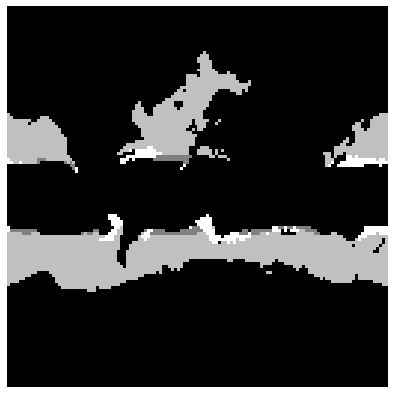

In [12]:
image(merged_pyramid.children[0]['all_variables'][2])